In [2]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

mat_data_set = [()]
# Load MATLAB file
mat_file = r'C:\Device5_ 1.mat' 
mat_data = scipy.io.loadmat(mat_file)
mat_data_set = np.append(mat_data_set, mat_data)

mat_file = r'C:\Device2  1.mat' 
mat_data = scipy.io.loadmat(mat_file)
mat_data_set = np.append(mat_data_set, mat_data)

mat_file = r'C:\Device3  1.mat' 
mat_data = scipy.io.loadmat(mat_file)
mat_data_set = np.append(mat_data_set, mat_data)

mat_file = r'C:\Device4  1.mat' 
mat_data = scipy.io.loadmat(mat_file)
mat_data_set = np.append(mat_data_set, mat_data)

#j=0 dev5
#j=1 dev2
#j=2 dev3
#j=3 dev4

ce_window_smooth = [None] * len(mat_data_set)

for j in range(len(mat_data_set)):
    measurement = mat_data_set[j]['measurement']
    transient = measurement['transient']
    
    total_time = 0
    new_time = 0
    original = 0 
    time = np.array([])
    ce_data_list = []
    
    for i in range(len(transient[0,0][0])):
        date_str = transient[0,0][0][i][0][0]
        time_str = date_str.split(' ')[1]
        hour, minute, second = map(int, time_str.split(':'))
        
        new_time = hour*3600 + minute*60 + second
        if i == 0:
            original = new_time
        total_time = new_time - original
    
        time = np.append(time, total_time)
        
        ce_data = transient[0,0][0][i][2][0][0][3][0]
        ce_data_list.append(ce_data)
    
    ce_data_array = np.array(ce_data_list) 
    
    ce_sampling_data = [()]
    for i in range(len(ce_data_array)):
        if time[i]>=2000 and np.min(ce_data_array[i])<=4.0:
            break
        ce_sampling_data = np.append(ce_sampling_data, np.average(ce_data_array[i]))
    
    def calculate_weighted_average(x, t, span=15):
        theta = 2 / (span + 1)
        numerator = 0
        denominator = 0
    
        for i in range(t + 1):
            weight = (1 - theta) ** (t - i)
            numerator += weight * x[i]
            denominator += weight
    
        yt = numerator / denominator
        return yt
    
    span = 15
    ce_window_smooth[j] = np.zeros(len(ce_sampling_data))
    for t in range(len(ce_sampling_data)):
        ce_window_smooth[j][t] = calculate_weighted_average(ce_sampling_data, t, span)

print("Done")

Done


In [3]:
alpha = np.array([0, 0.1, 0.3, 0.5, 0.7, 0.9])
type(alpha)

numpy.ndarray

In [4]:
output_array = [None] * len(alpha)
output_array

[None, None, None, None, None, None]

In [5]:
alpha_index = 0 #rnn alpha 0

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class CustomRNN(nn.Module):
    def __init__(self):
        super(CustomRNN, self).__init__()
        # Recurrent layer with 80 neurons
        self.rnn = nn.RNN(input_size=5, hidden_size=80, nonlinearity='tanh', batch_first=True)
        # Fully connected layer with 10 neurons
        self.fc1 = nn.Linear(80, 10)
        # Fully connected layer with 1 neuron
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        # Pass through RNN layer
        rnn_out, _ = self.rnn(x)  # rnn_out: [batch_size, seq_len, 80]
        # Take the last time step output from RNN
        rnn_out_last = rnn_out[:, -1, :]  # [batch_size, 80]
        # Pass through first fully connected layer
        fc1_out = self.fc1(rnn_out_last)  # [batch_size, 10]
        # Pass through second fully connected layer
        output = self.fc2(fc1_out)  # [batch_size, 1]
        return output

# Model, loss, and optimizer
model = CustomRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for q in range(len(mat_data_set)):
    if q in [1, 2, 3]:
        data = ce_window_smooth[q]
        
        # Prepare sliding window dataset
        window_size = 5
        inputs = []
        labels = []
        for i in range(len(data) - window_size):
            inputs.append(data[i:i + window_size])
            labels.append(data[i + window_size])
        
        inputs = torch.tensor(np.array(inputs), dtype=torch.float32)  # Convert numpy array to tensor
        labels = torch.tensor(np.array(labels), dtype=torch.float32).unsqueeze(1)  # Convert numpy array to tensor
        
        # Reshape inputs to match RNN input format
        inputs = inputs.unsqueeze(1)  # Shape: [93, 1, 10] (batch_size, seq_len, input_size)
        
        # Training loop
        epochs = 500
        for epoch in range(epochs):
            model.train()
        
            # Zero the gradients
            optimizer.zero_grad()
        
            # Forward pass
            outputs = model(inputs)  # Shape: [batch_size, 1]
        
            # Compute loss
            loss = (1-alpha[alpha_index])*criterion(outputs, labels)
        
            # Backward pass
            loss.backward()
        
            # Update weights
            optimizer.step()
        
            # Print loss every 10 epochs
            #if (epoch + 1) % 10 == 0:
                #print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
        
        # Evaluate on the entire dataset
        model.eval()
        with torch.no_grad():
            final_outputs_1 = model(inputs)

test_data_index=0
data = ce_window_smooth[test_data_index]
        
# Prepare sliding window dataset
window_size = 5
inputs = []
labels = []
for i in range(len(data) - window_size):
    inputs.append(data[i:i + window_size])
    labels.append(data[i + window_size])

inputs = torch.tensor(np.array(inputs), dtype=torch.float32)  # Convert numpy array to tensor
labels = torch.tensor(np.array(labels), dtype=torch.float32).unsqueeze(1)  # Convert numpy array to tensor

# Reshape inputs to match RNN input format
inputs = inputs.unsqueeze(1)  # Shape: [93, 1, 10] (batch_size, seq_len, input_size)

# Evaluate on the entire dataset
model.eval()
with torch.no_grad():
    final_outputs_1 = model(inputs)
    output_array[alpha_index] = final_outputs_1.squeeze().numpy()

    #print("Final outputs:", output_array[q])
print("Done")

Done


In [6]:
alpha_index = 1 #pinn alpha 0.1

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class CustomRNN(nn.Module):
    def __init__(self):
        super(CustomRNN, self).__init__()
        # Recurrent layer with 80 neurons
        self.rnn = nn.RNN(input_size=5, hidden_size=80, nonlinearity='tanh', batch_first=True)
        # Fully connected layer with 10 neurons
        self.fc1 = nn.Linear(80, 10)
        # Fully connected layer with 1 neuron
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        # Pass through RNN layer
        rnn_out, _ = self.rnn(x)  # rnn_out: [batch_size, seq_len, 80]
        # Take the last time step output from RNN
        rnn_out_last = rnn_out[:, -1, :]  # [batch_size, 80]
        # Pass through first fully connected layer
        fc1_out = self.fc1(rnn_out_last)  # [batch_size, 10]
        # Pass through second fully connected layer
        output = self.fc2(fc1_out)  # [batch_size, 1]
        return output

# Model, loss, and optimizer
model = CustomRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for q in range(len(mat_data_set)):
    if q in [1, 2, 3]:
        data = ce_window_smooth[q]
        
        # Prepare sliding window dataset
        window_size = 5
        inputs = []
        labels = []
        for i in range(len(data) - window_size):
            inputs.append(data[i:i + window_size])
            labels.append(data[i + window_size])
        
        inputs = torch.tensor(np.array(inputs), dtype=torch.float32)  # Convert numpy array to tensor
        labels = torch.tensor(np.array(labels), dtype=torch.float32).unsqueeze(1)  # Convert numpy array to tensor
        
        # Reshape inputs to match RNN input format
        inputs = inputs.unsqueeze(1)  # Shape: [93, 1, 10] (batch_size, seq_len, input_size)
        
        # Training loop
        epochs = 500
        for epoch in range(epochs):
            model.train()
        
            # Zero the gradients
            optimizer.zero_grad()
        
            # Forward pass
            outputs = model(inputs)  # Shape: [batch_size, 1]
        
            # Compute loss
            loss = (1-alpha[alpha_index])*criterion(outputs, labels)
        
            # Backward pass
            loss.backward()
        
            # Update weights
            optimizer.step()
        
            # Print loss every 10 epochs
            #if (epoch + 1) % 10 == 0:
                #print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
        
        # Evaluate on the entire dataset
        model.eval()
        with torch.no_grad():
            final_outputs_1 = model(inputs)

test_data_index=0
data = ce_window_smooth[test_data_index]
        
# Prepare sliding window dataset
window_size = 5
inputs = []
labels = []
for i in range(len(data) - window_size):
    inputs.append(data[i:i + window_size])
    labels.append(data[i + window_size])

inputs = torch.tensor(np.array(inputs), dtype=torch.float32)  # Convert numpy array to tensor
labels = torch.tensor(np.array(labels), dtype=torch.float32).unsqueeze(1)  # Convert numpy array to tensor

# Reshape inputs to match RNN input format
inputs = inputs.unsqueeze(1)  # Shape: [93, 1, 10] (batch_size, seq_len, input_size)

# Evaluate on the entire dataset
model.eval()
with torch.no_grad():
    final_outputs_1 = model(inputs)
    output_array[alpha_index] = final_outputs_1.squeeze().numpy()

    #print("Final outputs:", output_array[q])
print("Done")

Done


In [7]:
alpha_index = 2 #pinn alpha 0.3

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class CustomRNN(nn.Module):
    def __init__(self):
        super(CustomRNN, self).__init__()
        # Recurrent layer with 80 neurons
        self.rnn = nn.RNN(input_size=5, hidden_size=80, nonlinearity='tanh', batch_first=True)
        # Fully connected layer with 10 neurons
        self.fc1 = nn.Linear(80, 10)
        # Fully connected layer with 1 neuron
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        # Pass through RNN layer
        rnn_out, _ = self.rnn(x)  # rnn_out: [batch_size, seq_len, 80]
        # Take the last time step output from RNN
        rnn_out_last = rnn_out[:, -1, :]  # [batch_size, 80]
        # Pass through first fully connected layer
        fc1_out = self.fc1(rnn_out_last)  # [batch_size, 10]
        # Pass through second fully connected layer
        output = self.fc2(fc1_out)  # [batch_size, 1]
        return output

# Model, loss, and optimizer
model = CustomRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for q in range(len(mat_data_set)):
    if q in [1, 2, 3]:
        data = ce_window_smooth[q]
        
        # Prepare sliding window dataset
        window_size = 5
        inputs = []
        labels = []
        for i in range(len(data) - window_size):
            inputs.append(data[i:i + window_size])
            labels.append(data[i + window_size])
        
        inputs = torch.tensor(np.array(inputs), dtype=torch.float32)  # Convert numpy array to tensor
        labels = torch.tensor(np.array(labels), dtype=torch.float32).unsqueeze(1)  # Convert numpy array to tensor
        
        # Reshape inputs to match RNN input format
        inputs = inputs.unsqueeze(1)  # Shape: [93, 1, 10] (batch_size, seq_len, input_size)
        
        # Training loop
        epochs = 500
        for epoch in range(epochs):
            model.train()
        
            # Zero the gradients
            optimizer.zero_grad()
        
            # Forward pass
            outputs = model(inputs)  # Shape: [batch_size, 1]
        
            # Compute loss
            loss = (1-alpha[alpha_index])*criterion(outputs, labels)
        
            # Backward pass
            loss.backward()
        
            # Update weights
            optimizer.step()
        
            # Print loss every 10 epochs
            #if (epoch + 1) % 10 == 0:
                #print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
        
        # Evaluate on the entire dataset
        model.eval()
        with torch.no_grad():
            final_outputs_1 = model(inputs)

test_data_index=0
data = ce_window_smooth[test_data_index]
        
# Prepare sliding window dataset
window_size = 5
inputs = []
labels = []
for i in range(len(data) - window_size):
    inputs.append(data[i:i + window_size])
    labels.append(data[i + window_size])

inputs = torch.tensor(np.array(inputs), dtype=torch.float32)  # Convert numpy array to tensor
labels = torch.tensor(np.array(labels), dtype=torch.float32).unsqueeze(1)  # Convert numpy array to tensor

# Reshape inputs to match RNN input format
inputs = inputs.unsqueeze(1)  # Shape: [93, 1, 10] (batch_size, seq_len, input_size)

# Evaluate on the entire dataset
model.eval()
with torch.no_grad():
    final_outputs_1 = model(inputs)
    output_array[alpha_index] = final_outputs_1.squeeze().numpy()

    #print("Final outputs:", output_array[q])
print("Done")

Done


In [8]:
alpha_index = 3 #pinn alpha 0.5

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class CustomRNN(nn.Module):
    def __init__(self):
        super(CustomRNN, self).__init__()
        # Recurrent layer with 80 neurons
        self.rnn = nn.RNN(input_size=5, hidden_size=80, nonlinearity='tanh', batch_first=True)
        # Fully connected layer with 10 neurons
        self.fc1 = nn.Linear(80, 10)
        # Fully connected layer with 1 neuron
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        # Pass through RNN layer
        rnn_out, _ = self.rnn(x)  # rnn_out: [batch_size, seq_len, 80]
        # Take the last time step output from RNN
        rnn_out_last = rnn_out[:, -1, :]  # [batch_size, 80]
        # Pass through first fully connected layer
        fc1_out = self.fc1(rnn_out_last)  # [batch_size, 10]
        # Pass through second fully connected layer
        output = self.fc2(fc1_out)  # [batch_size, 1]
        return output

# Model, loss, and optimizer
model = CustomRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for q in range(len(mat_data_set)):
    if q in [1, 2, 3]:
        data = ce_window_smooth[q]
        
        # Prepare sliding window dataset
        window_size = 5
        inputs = []
        labels = []
        for i in range(len(data) - window_size):
            inputs.append(data[i:i + window_size])
            labels.append(data[i + window_size])
        
        inputs = torch.tensor(np.array(inputs), dtype=torch.float32)  # Convert numpy array to tensor
        labels = torch.tensor(np.array(labels), dtype=torch.float32).unsqueeze(1)  # Convert numpy array to tensor
        
        # Reshape inputs to match RNN input format
        inputs = inputs.unsqueeze(1)  # Shape: [93, 1, 10] (batch_size, seq_len, input_size)
        
        # Training loop
        epochs = 500
        for epoch in range(epochs):
            model.train()
        
            # Zero the gradients
            optimizer.zero_grad()
        
            # Forward pass
            outputs = model(inputs)  # Shape: [batch_size, 1]
        
            # Compute loss
            loss = (1-alpha[alpha_index])*criterion(outputs, labels)
        
            # Backward pass
            loss.backward()
        
            # Update weights
            optimizer.step()
        
            # Print loss every 10 epochs
            #if (epoch + 1) % 10 == 0:
                #print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
        
        # Evaluate on the entire dataset
        model.eval()
        with torch.no_grad():
            final_outputs_1 = model(inputs)

test_data_index=0
data = ce_window_smooth[test_data_index]
        
# Prepare sliding window dataset
window_size = 5
inputs = []
labels = []
for i in range(len(data) - window_size):
    inputs.append(data[i:i + window_size])
    labels.append(data[i + window_size])

inputs = torch.tensor(np.array(inputs), dtype=torch.float32)  # Convert numpy array to tensor
labels = torch.tensor(np.array(labels), dtype=torch.float32).unsqueeze(1)  # Convert numpy array to tensor

# Reshape inputs to match RNN input format
inputs = inputs.unsqueeze(1)  # Shape: [93, 1, 10] (batch_size, seq_len, input_size)

# Evaluate on the entire dataset
model.eval()
with torch.no_grad():
    final_outputs_1 = model(inputs)
    output_array[alpha_index] = final_outputs_1.squeeze().numpy()

    #print("Final outputs:", output_array[q])
print("Done")

Done


In [9]:
alpha_index = 4 #pinn alpha 0.7

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class CustomRNN(nn.Module):
    def __init__(self):
        super(CustomRNN, self).__init__()
        # Recurrent layer with 80 neurons
        self.rnn = nn.RNN(input_size=5, hidden_size=80, nonlinearity='tanh', batch_first=True)
        # Fully connected layer with 10 neurons
        self.fc1 = nn.Linear(80, 10)
        # Fully connected layer with 1 neuron
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        # Pass through RNN layer
        rnn_out, _ = self.rnn(x)  # rnn_out: [batch_size, seq_len, 80]
        # Take the last time step output from RNN
        rnn_out_last = rnn_out[:, -1, :]  # [batch_size, 80]
        # Pass through first fully connected layer
        fc1_out = self.fc1(rnn_out_last)  # [batch_size, 10]
        # Pass through second fully connected layer
        output = self.fc2(fc1_out)  # [batch_size, 1]
        return output

# Model, loss, and optimizer
model = CustomRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for q in range(len(mat_data_set)):
    if q in [1, 2, 3]:
        data = ce_window_smooth[q]
        
        # Prepare sliding window dataset
        window_size = 5
        inputs = []
        labels = []
        for i in range(len(data) - window_size):
            inputs.append(data[i:i + window_size])
            labels.append(data[i + window_size])
        
        inputs = torch.tensor(np.array(inputs), dtype=torch.float32)  # Convert numpy array to tensor
        labels = torch.tensor(np.array(labels), dtype=torch.float32).unsqueeze(1)  # Convert numpy array to tensor
        
        # Reshape inputs to match RNN input format
        inputs = inputs.unsqueeze(1)  # Shape: [93, 1, 10] (batch_size, seq_len, input_size)
        
        # Training loop
        epochs = 500
        for epoch in range(epochs):
            model.train()
        
            # Zero the gradients
            optimizer.zero_grad()
        
            # Forward pass
            outputs = model(inputs)  # Shape: [batch_size, 1]
        
            # Compute loss
            loss = (1-alpha[alpha_index])*criterion(outputs, labels)
        
            # Backward pass
            loss.backward()
        
            # Update weights
            optimizer.step()
        
            # Print loss every 10 epochs
            #if (epoch + 1) % 10 == 0:
                #print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
        
        # Evaluate on the entire dataset
        model.eval()
        with torch.no_grad():
            final_outputs_1 = model(inputs)

test_data_index=0
data = ce_window_smooth[test_data_index]
        
# Prepare sliding window dataset
window_size = 5
inputs = []
labels = []
for i in range(len(data) - window_size):
    inputs.append(data[i:i + window_size])
    labels.append(data[i + window_size])

inputs = torch.tensor(np.array(inputs), dtype=torch.float32)  # Convert numpy array to tensor
labels = torch.tensor(np.array(labels), dtype=torch.float32).unsqueeze(1)  # Convert numpy array to tensor

# Reshape inputs to match RNN input format
inputs = inputs.unsqueeze(1)  # Shape: [93, 1, 10] (batch_size, seq_len, input_size)

# Evaluate on the entire dataset
model.eval()
with torch.no_grad():
    final_outputs_1 = model(inputs)
    output_array[alpha_index] = final_outputs_1.squeeze().numpy()

    #print("Final outputs:", output_array[q])
print("Done")

Done


In [10]:
alpha_index = 5 #pinn alpha 0.9

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class CustomRNN(nn.Module):
    def __init__(self):
        super(CustomRNN, self).__init__()
        # Recurrent layer with 80 neurons
        self.rnn = nn.RNN(input_size=5, hidden_size=80, nonlinearity='tanh', batch_first=True)
        # Fully connected layer with 10 neurons
        self.fc1 = nn.Linear(80, 10)
        # Fully connected layer with 1 neuron
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        # Pass through RNN layer
        rnn_out, _ = self.rnn(x)  # rnn_out: [batch_size, seq_len, 80]
        # Take the last time step output from RNN
        rnn_out_last = rnn_out[:, -1, :]  # [batch_size, 80]
        # Pass through first fully connected layer
        fc1_out = self.fc1(rnn_out_last)  # [batch_size, 10]
        # Pass through second fully connected layer
        output = self.fc2(fc1_out)  # [batch_size, 1]
        return output

# Model, loss, and optimizer
model = CustomRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for q in range(len(mat_data_set)):
    if q in [1, 2, 3]:
        data = ce_window_smooth[q]
        
        # Prepare sliding window dataset
        window_size = 5
        inputs = []
        labels = []
        for i in range(len(data) - window_size):
            inputs.append(data[i:i + window_size])
            labels.append(data[i + window_size])
        
        inputs = torch.tensor(np.array(inputs), dtype=torch.float32)  # Convert numpy array to tensor
        labels = torch.tensor(np.array(labels), dtype=torch.float32).unsqueeze(1)  # Convert numpy array to tensor
        
        # Reshape inputs to match RNN input format
        inputs = inputs.unsqueeze(1)  # Shape: [93, 1, 10] (batch_size, seq_len, input_size)
        
        # Training loop
        epochs = 500
        for epoch in range(epochs):
            model.train()
        
            # Zero the gradients
            optimizer.zero_grad()
        
            # Forward pass
            outputs = model(inputs)  # Shape: [batch_size, 1]
        
            # Compute loss
            loss = (1-alpha[alpha_index])*criterion(outputs, labels)
        
            # Backward pass
            loss.backward()
        
            # Update weights
            optimizer.step()
        
            # Print loss every 10 epochs
            #if (epoch + 1) % 10 == 0:
                #print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
        
        # Evaluate on the entire dataset
        model.eval()
        with torch.no_grad():
            final_outputs_1 = model(inputs)

test_data_index=0
data = ce_window_smooth[test_data_index]
        
# Prepare sliding window dataset
window_size = 5
inputs = []
labels = []
for i in range(len(data) - window_size):
    inputs.append(data[i:i + window_size])
    labels.append(data[i + window_size])

inputs = torch.tensor(np.array(inputs), dtype=torch.float32)  # Convert numpy array to tensor
labels = torch.tensor(np.array(labels), dtype=torch.float32).unsqueeze(1)  # Convert numpy array to tensor

# Reshape inputs to match RNN input format
inputs = inputs.unsqueeze(1)  # Shape: [93, 1, 10] (batch_size, seq_len, input_size)

# Evaluate on the entire dataset
model.eval()
with torch.no_grad():
    final_outputs_1 = model(inputs)
    output_array[alpha_index] = final_outputs_1.squeeze().numpy()

    #print("Final outputs:", output_array[q])
print("Done")

Done


In [11]:
output_array_new = [None]*len(alpha)
differnce_points_add = [None]*len(alpha)
for q in range(len(alpha)):
    len_ori = len(ce_window_smooth[0])
    len_new = len(output_array[q])
    
    differnce_points_add[q] = ce_window_smooth[0][len_new:len_ori+1]
    output_array_new[q] = output_array[q]
    output_array_new[q] = np.append(output_array_new[q], differnce_points_add[q])
    #print(len(output_array_new[q])-len(ce_window_smooth[q])

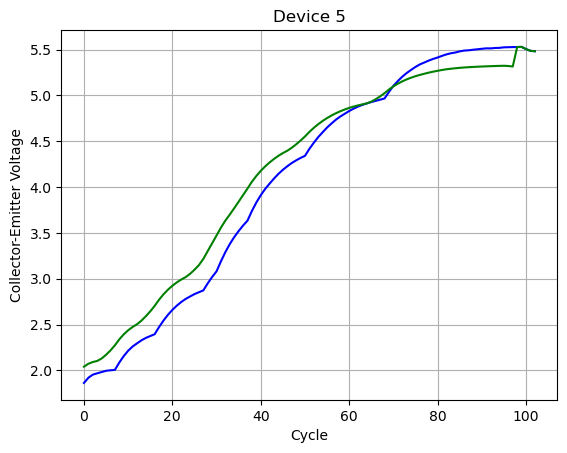

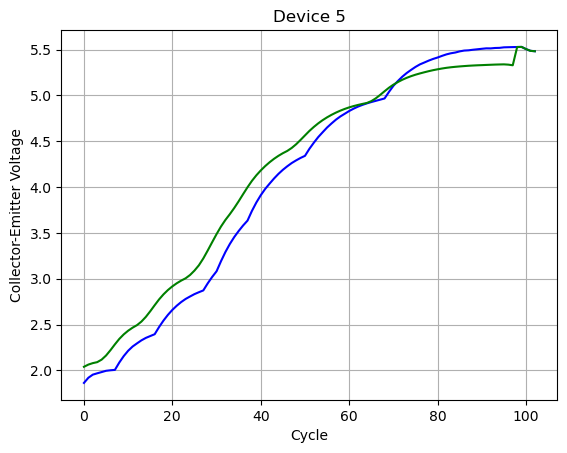

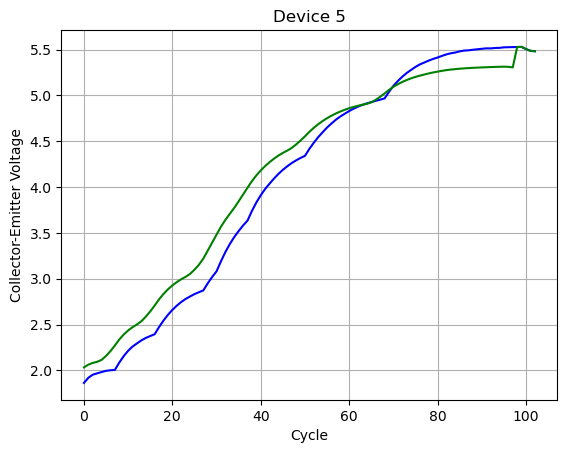

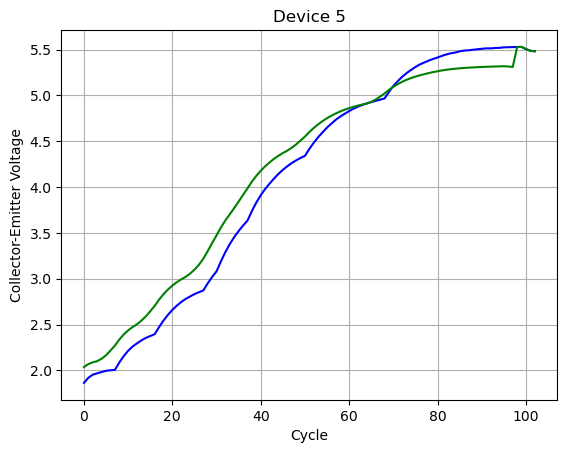

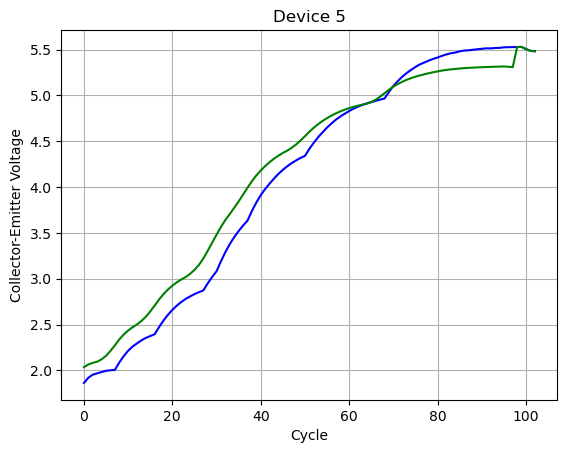

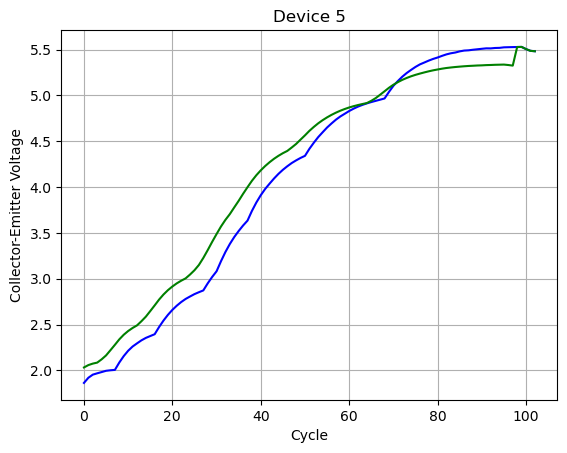

In [12]:
for q in range(len(alpha)):
    x_values = np.arange(len(ce_window_smooth[0])) #original
    plt.plot(x_values, ce_window_smooth[0], color="blue")
    
    x_values_rnn = np.arange(len(output_array_new[q])) #rnn without test train split
    plt.plot(x_values_rnn, output_array_new[q], color="green")
    
    plt.xlabel("Cycle")
    plt.ylabel("Collector-Emitter Voltage")
    plt.title("Device 5")
    plt.grid(True)
    plt.show()

In [13]:
import numpy as np

# Function to calculate MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Function to calculate R² (Coefficient of Determination)
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)  # Residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # Total sum of squares
    return 1 - (ss_res / ss_tot)

# Function to calculate MAE
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

print("Done")

Done


In [14]:
mse = [()]
r2 = [()]
mae = [()]
y_true = ce_window_smooth[0]
for q in range(len(alpha)):
    y_pred = output_array_new[q]
    # Calculate MSE
    mse = np.append(mse,mean_squared_error(y_true, y_pred))
  
    # Calculate R²
    r2 = np.append(r2, r2_score(y_true, y_pred)*100)
    
    # Calculate MAE
    mae = np.append(mae, mean_absolute_error(y_true, y_pred))

print(mse)
print(r2)
print(mae)

[0.04195336 0.04134421 0.04321769 0.04250225 0.04294897 0.04167075]
[97.35119468 97.38965393 97.27136849 97.31653923 97.28833493 97.36903778]
[0.17726998 0.17478478 0.17965749 0.17844249 0.1791466  0.17548023]
